In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import healpy as hp
from astropy.table import Table
import camb
from camb import model, initialpower

from numpy import linalg as LA
import utils
from utils import m_l as m_l
from utils import bin_l as bin_l
import pymaster as nmt

from Pseudo_Cl import Pseudo_Cl
from PurifyB import PurifyB
plt.rcParams['figure.figsize'] = (10.0, 8.0)

NSIDE = 1024
ORDERING = RING in fits file
INDXSCHM = IMPLICIT


# functions

In [87]:
def plot_ps(cls, label):
#     plt.figure(figsize = (10,8));
    
    if len(cls.shape) == 1:
        _ell = np.arange(len(cls)); _ell2 = _ell[2:];
        plt.loglog(_ell2, _ell2*(_ell2+1)/2/np.pi*cls[2:], '-',label = label );
        
    else:
        _ell = np.arange(len(cls[0])); _ell2 = _ell[2:];
        plt.loglog(_ell2, _ell2*(_ell2+1)/2/np.pi*cls[1][2:],label = 'EE');
        plt.loglog(_ell2, _ell2*(_ell2+1)/2/np.pi*cls[2][2:],label = 'BB');
    
    plt.legend(fontsize = 20);
    
def deconv(maps, beam_in, beam_out, lmax):
    ''' 
    Beam in unit of arc-miniute.
    This function changes the value of the input map itself.
    
    '''
    
    _maps = np.copy(maps)
    for j in range(1,3): ### only for Q\U;
        _maps[j] = hp.sphtfunc.decovlving(_maps[j], fwhm = beam_in/60/180*np.pi, lmax = lmax, verbose = False)
        _maps[j] = hp.smoothing(_maps[j], fwhm = beam_out/60/180*np.pi, lmax = lmax, verbose = False)
    return _maps


def smooth(maps, beam_out, lmax):
    _maps = np.copy(maps);
    for j in range(1,3):                        ###for Q and U. Exclude I.
        _maps[j] = hp.smoothing(_maps[j], fwhm = beam_out/60/180*np.pi, lmax = lmax, verbose = False)
    return _maps

# ali_ma = hp.ud_grade(hp.read_map('/smc/jianyao/Ali_maps/Ali_mask_1024.fits'), nside_out = 512)#, verbose=False)
# ali_ma = hp.ud_grade(hp.read_map('/smc/jianyao/Ali_maps/ali_mask_wo_edge.fits'), nside_out = 512)

ali_ma = hp.read_map('/smc/jianyao/Ali_maps/ali_mask_wo_edge_512.fits')

def Mask(maps): 
    maps_ma = hp.ma(maps)
    maps_ma.mask = np.logical_not(ali_ma)
    return maps_ma

def Power_spectrum(maps,R, lmax):
    ''' 
    revised for upper-triangle of the matrix.
    Input:
    maps with multi-frequencies IQU sky maps. 
    Galactic plane cut for calculating the power spectrum.
    lmax.  

    Return: EE and BB cross power spectrum. 
    Shape (2, lmax, nf, nf)
    '''
    n_f = len(maps)
    cl = np.ones((2, n_f*n_f, lmax +1)); Cl = np.zeros((2, lmax+1, n_f, n_f))
    k = 0
    for i in range(n_f):
        for j in range(n_f):
            
            if i >= j :
                cross_ps = hp.anafast(maps[i], maps[j], lmax = lmax, gal_cut=R, nspec=3) ## TT, EE, BB
            else:
                cross_ps = np.zeros((3, lmax+1)) 
            cl[0][k] = cross_ps[1]; cl[1][k] = cross_ps[2]  ## calculate the E and B_mode power spectrum 
            k += 1
            
    for l in range(lmax+1):
        Cl[0, l, : , :] = cl[0, :,l].reshape(n_f, n_f); Cl[1, l, : , :] = cl[1, :,l].reshape(n_f, n_f)
        Cl[0, l] += Cl[0, l].T - np.diag(Cl[0, l].diagonal()) ; Cl[1, l] += Cl[1, l].T - np.diag(Cl[1, l].diagonal()) 
    return Cl

NSIDE = 1024
ORDERING = RING in fits file
INDXSCHM = IMPLICIT
NSIDE = 512
ORDERING = RING in fits file
INDXSCHM = IMPLICIT


# Public area

In [88]:
nside = 512; Nf = 4; lmax = 1000; Q = int(lmax/20)

In [98]:
Cl_cmb = np.zeros((SamNum,3, lmax + 1))
for n in range(SamNum):
    cmb_i = hp.ud_grade(hp.read_map('/fnx/jianyao/cmb_0.05_realizations/cmb_IQU_%s.fits'%(n), field = None, verbose = False), nside_out = 512)
    cmb_ma = Mask(smooth((cmb_i), beam_out=19, lmax = 1500))
    Cl_cmb[n] = hp.anafast(cmb_ma, lmax = lmax, nspec = 3)

In [99]:
clee_clean_std = utils.bin_l(np.std(Cl_cmb, axis = 0)[1], lmax, Q); clbb_clean_std = utils.bin_l(np.std(Cl_cmb, axis = 0)[2], lmax, Q)
clee_clean = utils.bin_l(np.mean(Cl_cmb, axis = 0)[1], lmax, Q); clbb_clean = utils.bin_l(np.mean(Cl_cmb, axis = 0)[2], lmax, Q)

In [91]:
cl_clean_44_mean = np.row_stack((clee_clean, clbb_clean))
cl_clean_44_std = np.row_stack((clee_clean_std, clbb_clean_std))

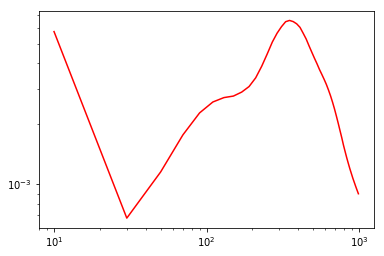

In [105]:
ll = utils.get_ell(lmax, Q)
el2 = utils.l2(Ell)

plt.loglog(Ell, el2*clbb_clean, 'r-',label = 'anafast')

In [ ]:
## 95GHz: cl_clean; clean_std

In [449]:
np.save('/fnx/jianyao/cmb_0.05_realizations/cl_clean_95GHz_mean_std.npy', np.row_stack((cl_clean, cl_clean_std)))

## test for Mask_0 and Mask

# CMB should beamed first, and foreground should downgrade to the same resolution

In [3]:
# 13.0765 arcmin, K_CMB
fore70 = hp.ud_grade(hp.read_map('/fnx/jianyao/LFI_070/group2_map_detector_F070.fits', field = None, verbose = False), nside_out = 512)*1e6

#27.9435 arcmin, K_CMB
fore44 = hp.ud_grade(hp.read_map('/fnx/jianyao/LFI_044/group2_map_detector_F044.fits', field = None, verbose = False), nside_out = 512)*1e6

### 19 arcmin, uK_CMB
fore95 = hp.ud_grade(hp.read_map('/fnx/jianyao/1205_observations_AliCPT/95GHz/group2_map_95GHz.fits', field = None, verbose = False), nside_out=512)  
### 11 arcmin, uK_CMB
fore150 = hp.ud_grade(hp.read_map('/fnx/jianyao/1205_observations_AliCPT/150GHz/group2_map_150GHz.fits', field = None, verbose = False), nside_out=512) 
 ###4.944 arcmin, K_CMB
fore353 = hp.ud_grade(hp.read_map('/fnx/jianyao/1205_observations_HFI_353/group2_map_detector_F353.fits', field = None, verbose = False), nside_out=512)*1e6

## single realization

In [10]:
noise_95_i = hp.ud_grade(hp.read_map('/fnx/jianyao/Noise_realizations/95GHz/noise_realizations_95GHz_1.fits', field = None, verbose = False),nside_out = 512)
noise_150_i = hp.ud_grade(hp.read_map('/fnx/jianyao/Noise_realizations/150GHz/noise_realizations_150GHz_1.fits', field = None, verbose = False),nside_out = 512)
noise_353_i = hp.ud_grade(hp.read_map('/fnx/jianyao/Noise_realizations/353GHZ_PLA/noise_353_full_map_mc_00001.fits', field = None, verbose = False),nside_out = 512)*1e6

In [11]:
total = np.zeros((Nf, 3, 12*nside**2))
total[0] = smooth(cmb_i, beam_out=19, lmax = 1500) + fore95 + noise_95_i
total[1] = deconv(smooth(cmb_i, beam_out=11, lmax = 1500) + fore150 + noise_150_i, beam_in = 11, beam_out = 19, lmax = 1500)
total[2] = deconv(smooth(cmb_i, beam_out=4.944, lmax = 1500) + fore353 + noise_353_i, beam_in = 4.944, beam_out = 19, lmax = 1500)
total_mask = Mask(total)

In [246]:
Fore = np.zeros((Nf, 3, 12*nside**2))
Fore[0] = fore95
Fore[1] = deconv(fore150, beam_in = 11, beam_out = 19, lmax = 1500)
Fore[2] = deconv(fore353, beam_in = 4.944, beam_out = 19, lmax = 1500)
Fore_mask = Mask(Fore)

In [12]:
Noise = np.zeros((Nf,3,12*nside**2))
Noise[0] = noise_95_i;  
Noise[1] = deconv(noise_150_i, beam_in = 11, beam_out = 19, lmax = 1500) ; 
Noise[2] = deconv(noise_353_i, beam_in = 4.944, beam_out = 19, lmax = 1500)
noise_mask = Mask(Noise)

In [247]:
fore_ps = Power_spectrum(Fore_mask, 0, lmax = lmax)

In [13]:
total_ps_i = Power_spectrum(total_mask, 0, lmax = lmax)
noise_ps_i = Power_spectrum(noise_mask, 0, lmax = lmax)

## Foreground only

In [284]:
sync = np.zeros((Nf, 3, 12*nside**2)); dust = np.zeros((Nf, 3, 12*nside**2))
# uK_CMB
sync_95 = hp.ud_grade(hp.read_map('/fnx/jianyao/1205_skyinband_AliCPT/95GHz/synchrotron_map_95GHz.fits', field = (0,1,2), verbose = False), nside_out=512)
sync_150 = hp.ud_grade(hp.read_map('/fnx/jianyao/1205_skyinband_AliCPT/150GHz/synchrotron_map_150GHz.fits', field = (0,1,2), verbose = False), nside_out=512)
#K_CMB
sync_353 = hp.ud_grade(hp.read_map('/fnx/jianyao/1205_skyinband_HFI_353/detector_F353/synchrotron_map_detector_F353.fits', field = (0,1,2), verbose = False), nside_out=512)*1e6 

sync[0] = smooth(sync_95, beam_out=11, lmax = 1500)
sync[1] = smooth(sync_150, beam_out=11, lmax = 1500)
sync[2] = smooth(sync_353, beam_out=11, lmax = 1500)

In [291]:
dust = np.zeros((Nf, 3, 12*nside**2))
# uK_CMB
dust_95 = hp.ud_grade(hp.read_map('/fnx/jianyao/1205_skyinband_AliCPT/95GHz/thermaldust_map_95GHz.fits', field = (0,1,2), verbose = False), nside_out=512)
dust_150 = hp.ud_grade(hp.read_map('/fnx/jianyao/1205_skyinband_AliCPT/150GHz/thermaldust_map_150GHz.fits', field = (0,1,2), verbose = False), nside_out=512)
#K_CMB
dust_353 = hp.ud_grade(hp.read_map('/fnx/jianyao/1205_skyinband_HFI_353/detector_F353/thermaldust_map_detector_F353.fits', field = (0,1,2), verbose = False), nside_out=512)*1e6 

dust[0] = smooth(dust_95, beam_out=11, lmax = 1500)
dust[1] = smooth(dust_150, beam_out=11, lmax = 1500)
dust[2] = smooth(dust_353, beam_out=11, lmax = 1500)

In [292]:
sync_ps = Power_spectrum(Mask(sync), 0, lmax = lmax)
dust_ps = Power_spectrum(Mask(dust), 0, lmax = lmax)

## Save 100 realizations total maps

In [4]:
SamNum =100; beam_low = 27.9435; Nf = 3; nside = 512; lmax = 1000
## should use namaster instead; 2020-03-20 
for i in range(SamNum):
#     if i < 50:
#         noise_95 = hp.ud_grade(hp.read_map('/fnx/jianyao/Noise_realizations/95GHz/noise_realizations_95GHz_%s.fits'%(i), field = None, verbose = False),nside_out = nside)
#         noise_150 = hp.ud_grade(hp.read_map('/fnx/jianyao/Noise_realizations/150GHz/noise_realizations_150GHz_%s.fits'%(i), field = None, verbose = False),nside_out = nside)
#     else: 
#         noise_95 = hp.ud_grade(hp.read_map('/fnx/jianyao/Noise_realizations/95GHz/noise_95GHz_%s.fits'%(i), field = None, verbose = False),nside_out = nside)
#         noise_150 = hp.ud_grade(hp.read_map('/fnx/jianyao/Noise_realizations/150GHz/noise_150GHz_%s.fits'%(i), field = None, verbose = False),nside_out = nside)
    
#     # K_CMB, nside = 1024, IQU
# #     noise_70 = 1e6*hp.ud_grade(hp.read_map('/fnx/jianyao/Noise_realizations/70GHz_LFI/70GHz_LFI_noise_070_full_map_mc_%05d.fits'%i, field = None, verbose = False), nside_out=nside)
#     noise_44 = 1e6*hp.ud_grade(hp.read_map('/fnx/jianyao/Noise_realizations/44GHz_LFI/noise_044_full_map_mc_%05d.fits'%i, field = None, verbose = False), nside_out=nside)
# #     noise_353 = 1e6*hp.ud_grade(hp.read_map('/fnx/jianyao/Noise_realizations/353GHZ_PLA/noise_353_full_map_mc_%05d.fits'%i, field = None, verbose = False), nside_out=nside)
    
#     Noise = np.zeros((Nf,3,12*nside**2))
#     Noise[0] = noise_44;
# #     Noise[1] = deconv(noise_70, beam_in = 13.0765, beam_out = beam_low, lmax = lmax + 100);
#     Noise[1] = deconv(noise_95, beam_in = 19, beam_out = beam_low, lmax = lmax + 100);  
#     Noise[2] = deconv(noise_150, beam_in = 11, beam_out = beam_low, lmax = lmax + 100); 
# #     Noise[3] = 0 # deconv(noise_353, beam_in = 4.944, beam_out = beam_low, lmax = lmax + 100);
#     noise_ps_i = utils.Power_spectrum(Mask(Noise), 0, lmax = lmax);
#     np.save('/fnx/jianyao/ancillary_data/3_fre_44_with_noise/noise_ps/nl_deconv_masked_EB_%s.npy'%i, noise_ps_i)
    
    cmb_i = hp.ud_grade(hp.read_map('/fnx/jianyao/cmb_0.05_realizations/cmb_IQU_%s.fits'%(i), field = None, verbose = False), nside_out = 512)
    
    total = np.zeros((Nf, 3, 12*nside**2))
    total[0] = smooth(cmb_i, beam_out = beam_low, lmax = lmax + 100) + fore44 + noise_44 
#     total[1] = deconv(smooth(cmb_i, beam_out = 13.0765, lmax = lmax + 100) + fore70 + noise_70, beam_in = 13.0765, beam_out = beam_low, lmax = lmax + 100)
    total[1] = deconv(smooth(cmb_i, beam_out = 19, lmax = lmax + 100) + fore95 + noise_95, beam_in = 19, beam_out = beam_low, lmax = lmax + 100) #+ noise_95
    total[2] = deconv(smooth(cmb_i, beam_out=11, lmax = lmax + 100) + fore150 + noise_150, beam_in = 11, beam_out = beam_low, lmax = lmax + 100) #+ noise_150
#     total[3] = deconv(smooth(cmb_i, beam_out=4.944, lmax = lmax + 100) + fore353 , beam_in = 4.944, beam_out = beam_low, lmax = lmax + 100) #+ noise_353
    
#     np.save('/fnx/jianyao/ancillary_data/4_fre_44_wo_44_353_noise/total_map_unmasked/total_map_deconv_unmasked_IQU_%03d.npy'%i, total)
    total_mask = Mask(total)
    
    total_ps_i = utils.Power_spectrum(total_mask, 0, lmax = lmax)
    np.save('/fnx/jianyao/ancillary_data/3_fre_44_with_noise/total_ps/total_ps_deconv_masked_EB_%s.npy'%i, total_ps_i)

In [261]:
np.std(Mask(fore44[1]))

1.7620867934835762

In [263]:
np.std(Mask(fore95[1]))

0.4126445306823365

In [264]:
np.std(Mask(fore150[1]))

0.8227369885804516

# ILC

## ILC in harmonic space

### ILC implemented

In [80]:
Nf = 4

In [81]:
path = '/fnx/jianyao/ancillary_data/4_fre_plus_44/'
noise_ps_mean = np.zeros((2, lmax+1, Nf, Nf))

for n in range(SamNum):
    noise_ps_mean += np.load('%s/noise_ps/nl_deconv_masked_EB_%s.npy'%(path, n))

noise_ps_mean /= SamNum

In [86]:
SamNum = 100; Q = 50#lmax + 1 
# lmax = 1000,意味着有1001个l,Q应该等于1001; 想要得到干净的天图的时候，
names = ['Q_polarization', 'U_polarization']

Cl_ilc = np.zeros((SamNum, Q)); itera = 1; mode = 1; #Fore_cl= np.zeros((SamNum, Q)); sync_cl = np.zeros((SamNum, Q)); dust_cl = np.zeros((SamNum, Q))
for n in range(SamNum): 
  
    e = np.matrix(np.ones(Nf))
    total_ps_i = np.load('%s/total_ps/total_ps_deconv_masked_EB_%s.npy'%(path, n))
   
    ## Power_spectrum return EE and BB at the same time. So total_ps[0] = EE; total_ps[1] = BB
    noise_bin = utils.bin_l(noise_ps_mean[mode], lmax, Q); #noise_ps_mean[mode]#
    noise_ilc = np.zeros(Q); 
    total_bin_i = utils.bin_l(total_ps_i[mode], lmax, Q); #total_ps_i[mode]#
    
    # take some part of the cross power spectrum matrix
    total_bin = np.ones((Q, Nf,Nf))
    for q in range(Q):
        for i in range(Nf):
            for j in range(Nf):
                total_bin[q][i,j] = total_bin_i[q][i, j]
                
#     fore_bin = utils.bin_l(fore_ps[mode], lmax, Q); sync_bin = utils.bin_l(sync_ps[mode], lmax, Q); dust_bin = utils.bin_l(dust_ps[mode], lmax, Q);

    for r in range(itera):
        if r == 0:
            nuisance = noise_bin
            
        else:
            nuisance = total_bin - All_matrix(Cl_ilc[n], Nf)
            
        #calculate the weight
        W = np.matrix(np.zeros((Q, Nf)))
        noise_clean = np.zeros(Q)                                 ## to get the std of ILC CMB
        for l in range(Q):
            norm = e*np.linalg.pinv((total_bin[l]))*e.T
            noise_clean[l] = e*np.linalg.pinv(noise_bin[l])*e.T   ## to get the std of ILC CMB
            W[l,:] = e*np.linalg.pinv((total_bin[l]))/norm   
        
        for i in range(Q):
            
            ''' whether include noise_bin or not;  WNW = 1/(eN{-1}e.T)'''
            
            noise_ilc[i] = W[i,:]*(nuisance[i])*np.transpose(W[i,:])     #noise_bin　nuisance[i]
            Cl_ilc[n, i] = W[i,:]*(total_bin[i])*np.transpose(W[i,:]) #- noise_ilc[i]  #1.0/(e*np.linalg.pinv((total_bin[i]))*e.T) 
#             Fore_cl[n, i] =  W[i,:]*(fore_bin[i])*np.transpose(W[i,:]);
#             dust_cl[n, i] = W[i,:]*(dust_bin[i])*np.transpose(W[i,:]); sync_cl[n,i] = W[i,:]*(sync_bin[i])*np.transpose(W[i,:]);

#     total = np.load('/fnx/jianyao/ancillary_data/total_map/total_map_deconv_unmasked_IQU_%03d.npy'%n)
#     total_mask = Mask(total)
    
#     ### ILC results to cleaned CMB maps
#     m_num = int((1 + lmax+1)*(lmax+1 )/2) ## lmax = 1000,意味着有1001项
#     alm_Q = np.zeros((Nf, m_num), dtype = 'complex128'); alm_U = np.zeros((Nf, m_num), dtype = 'complex128')  ##almE\almB

#     for i in range(Nf):
#         alm_Q[i] = hp.map2alm(total_mask[i], lmax = lmax)[1]; # 95GHz, 150GHz, 353GHz
#         alm_U[i] = hp.map2alm(total_mask[i], lmax = lmax)[2]; 
    
#     alm_Q_clean = np.zeros(m_num,dtype = 'complex128'); alm_U_clean = np.zeros(m_num, dtype = 'complex128')

#     for l in np.arange(lmax + 1): 
#         alm_Q_clean[m_l(lmax, l)] = np.dot(np.array(W[l, :]),alm_Q[:,m_l(lmax, l)])[0] #np.dot(np.array(weight[l, :]),alm_Q[:,m_l(lmax, l)])[0]#
#         alm_U_clean[m_l(lmax, l)] = np.dot(np.array(W[l, :]),alm_U[:,m_l(lmax, l)])[0]

#     alm_Q_clean[m_l(lmax, 0)] = 0; alm_Q_clean[m_l(lmax, 1)] = 0
#     alm_U_clean[m_l(lmax, 0)] = 0; alm_U_clean[m_l(lmax, 1)] = 0
    
#     almT = np.zeros_like(alm_Q_clean)
#     cmb_clean = hp.alm2map(np.row_stack((almT, alm_Q_clean, alm_U_clean)), nside = nside, lmax = lmax)
    
#     hp.write_map('/fnx/jianyao/HS_clean_CMB_v2/Cleaned_QU_%03d.fits'%(n),cmb_clean[1:], coord='G', column_names= names, column_units='uK_CMB')

# fore_mean = np.mean(Fore_cl, axis=0)
cl_ilc_mean = np.mean(Cl_ilc, axis = 0)
cl_ilc_std = np.std(Cl_ilc, axis = 0)

In [10]:
Ell = utils.get_ell(lmax, Q)
el2 = utils.l2(Ell)

Ell_clean = utils.get_ell(lmax, 50)
el2_clean = utils.l2(Ell_clean)

In [9]:
cl_clean_44 = np.load('/fnx/jianyao/cmb_0.05_realizations/cl_clean_44GHz_mean_std.npy')[0:2]

Text(0.5, 1.0, 'noisy')

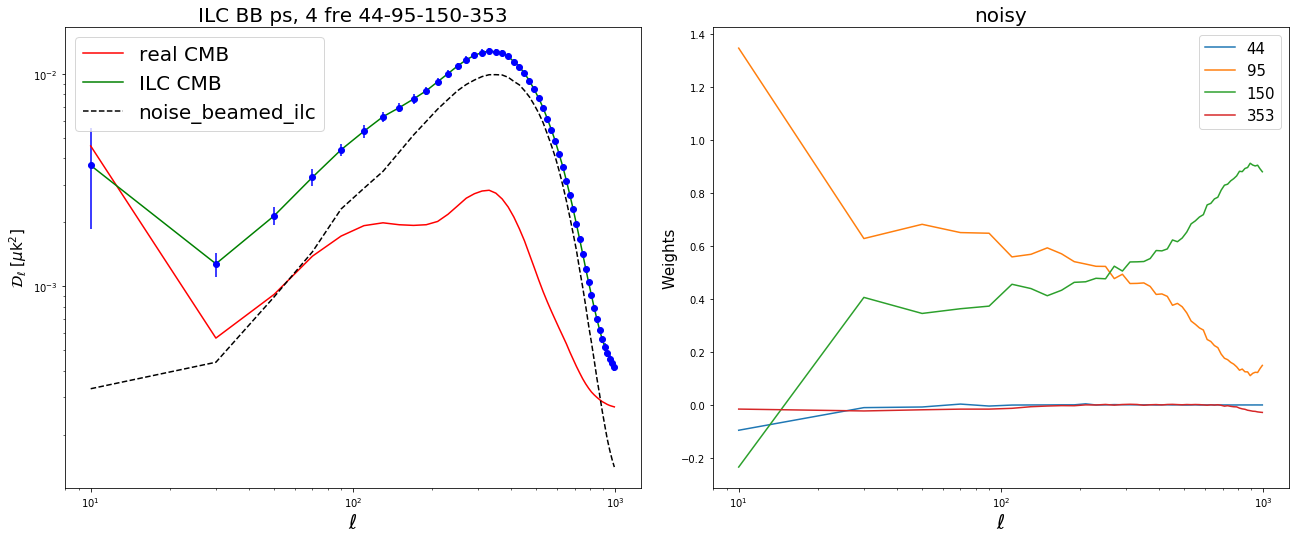

In [71]:
fig1 = plt.figure(1, figsize=(20,8)); psn = ['EE', 'BB']; fre = ['44', '95','150','353']
# plt.axis('off')
frame1=fig1.add_axes((.1,.1,.4,.8)) # x0, y0, width, height

plt.loglog(Ell_clean, el2_clean*cl_clean_44[mode], 'r-',label = 'real CMB')
plt.loglog(Ell, Ell*(Ell+1)/2/np.pi*(cl_ilc_mean), 'g-', label = 'ILC CMB')
plt.loglog(Ell, Ell*(Ell+1)/2/np.pi*noise_ilc, 'k--', label = 'noise_beamed_ilc')
# plt.loglog(Ell, Ell*(Ell+1)/2/np.pi*fore_mean, 'b--', label = 'Fore_ilc_residual')
# plt.loglog(Ell, Ell*(Ell+1)/2/np.pi*dust_mean, 'y--', label = 'Dust_ILC')
# plt.loglog(Ell, Ell*(Ell+1)/2/np.pi*sync_mean, 'k--', label = 'Synchrotron_ILC')

# plt.loglog(Ell, Ell*(Ell+1)/2/np.pi*bin_l(total_cl95[mode+1], lmax, Q), 'purple', label = 'total_ps 95GHz')
# plt.loglog(Ell, Ell*(Ell+1)/2/np.pi*bin_l(total_cl150[mode+1], lmax, Q), 'orange', label = 'total_ps 150GHz')
# plt.loglog(Ell, Ell*(Ell+1)/2/np.pi*bin_l(total_cl353[mode+1], lmax, Q), 'k-', label = 'total_ps 353GHz')

# plt.xscale('linear')
plt.errorbar(Ell,Ell*(Ell+1)*cl_ilc_mean/2/np.pi, yerr = Ell*(Ell+1)/2/np.pi*cl_ilc_std,fmt='bo',capthick = 0.1)
# plt.ylim(1e-4, 1e-1)
plt.xlabel('$\ell$', fontsize = 20); 
plt.ylabel(r'$\mathcal{D}_{\ell}$ [$\mu$k$^2$]', fontsize = 15)
plt.legend(fontsize = 20)
plt.title('ILC %s ps, %s fre 44-95-150-353'%(psn[mode], Nf), fontsize = 20)

frame2=fig1.add_axes((.55,.1,.4,.8))
for i in range(Nf):
    plt.plot(Ell, W[:, i], label = '%s'%fre[i])
plt.xscale('log')
plt.legend(fontsize = 15)
plt.ylabel('Weights', fontsize = 15)
plt.xlabel('$\ell$', fontsize = 20); 
plt.title('noisy',fontsize = 20)
# plt.semilogx(Ell, (cl_ilc - cls)/cls*100, 'k--')
# plt.axhline(0,color = 'k')
# plt.ylabel(r'$\Delta \mathcal{D}_\ell$/$\mathcal{D}^{real}_{\ell} $ [%]', fontsize = 15);plt.xlabel(r'$\ell$', fontsize = 20)
# plt.ylim(-100, 100)

# plt.savefig('/home/jianyao/Ali_maps/results/0316_no_noise/4_fre%s_ILC_all_noisy_44.jpg'%psn[mode], format = 'jpg')

In [115]:
cmb_clean_ustc = hp.read_map('/fnx/jianyao/HS_clean_CMB_v2/Cleaned_QU_099.fits', field = None)

NSIDE = 512
ORDERING = RING in fits file
INDXSCHM = IMPLICIT


In [117]:
cl_re = hp.anafast(np.row_stack((np.ones(12*nside**2),cmb_clean_ustc)), nspec = 3, lmax = lmax)

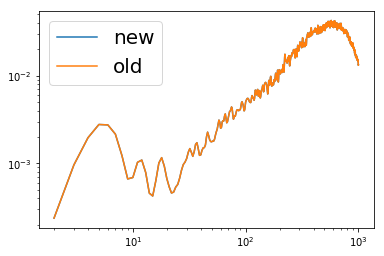

In [118]:
plot_ps(cl_re[2], label = 'new')
# plot_ps(cl_re[1], label = 'EE')

plot_ps(Cl_ilc[n], label = 'old')

### ILC cleand maps

In [38]:
m_num = int((1 + lmax)*(lmax+1 -1)/2) # the number of alm of lmax=l for m >= 0; m = 0,1 for l = 1; m = 0,1,2 for l = 2.
alm_Q = np.zeros((Nf, m_num), dtype = 'complex128'); alm_U = np.zeros((Nf, m_num), dtype = 'complex128')

for i in range(Nf):
    alm_Q[i] = hp.map2alm(total_mask[i], lmax = lmax-1)[1]; # 95GHz, 150GHz, 353GHz
    alm_U[i] = hp.map2alm(total_mask[i], lmax = lmax-1)[2]; 

In [39]:
alm_Q_clean = np.zeros(m_num,dtype = 'complex128'); alm_U_clean = np.zeros(m_num, dtype = 'complex128')

for l in np.arange(lmax):
    alm_Q_clean[m_l(lmax - 1, l)] = np.dot(np.array(W[l, :]),alm_Q[:,m_l(lmax - 1, l)])[0] #np.dot(np.array(weight[l, :]),alm_Q[:,m_l(lmax, l)])[0]#
    alm_U_clean[m_l(lmax - 1, l)] = np.dot(np.array(W[l, :]),alm_U[:,m_l(lmax - 1, l)])[0]
    
alm_Q_clean[m_l(lmax, 0)] = 0; alm_Q_clean[m_l(lmax, 1)] = 0
alm_U_clean[m_l(lmax, 0)] = 0; alm_U_clean[m_l(lmax, 1)] = 0

In [40]:
# Q_clean = hp.alm2map(alm_Q_clean, nside = nside, lmax = lmax - 1); U_clean = hp.alm2map(alm_U_clean, nside = nside, lmax = lmax - 1);
# I_clean = np.zeros_like(Q_clean)
almT = np.zeros_like(alm_Q_clean)
cmb_clean = hp.alm2map(np.row_stack((almT, alm_Q_clean, alm_U_clean)), nside = nside, lmax = lmax - 1)
# alm_total = hp.map2alm(cmb_clean)
# B_maps = hp.alm2map(alm_total[2], nside = nside, verbose = False)

Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin


In [41]:
cls_final = hp.anafast(Mask(cmb_clean), nspec=3, lmax = lmax)
# cls_final = hp.alm2cl(alm_U_clean)

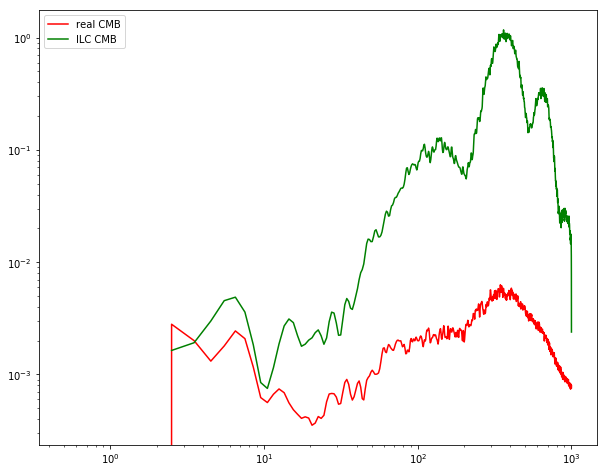

In [44]:
plt.loglog(Ell, Ell*(Ell+1)/2/np.pi*clbb_clean, 'r-',label = 'real CMB')
plt.loglog(Ell, Ell*(Ell+1)/2/np.pi*(cls_final[1][:lmax] - noise_ilc), 'g-', label = 'ILC CMB')
# plt.loglog(Ell, Ell*(Ell+1)/2/np.pi*noise_ilc, 'b--', label = 'noise_ilc')
# plt.loglog(Ell, Ell*(Ell+1)/2/np.pi*total_cl[2], 'k--', label = 'total_ps')

plt.legend()

In [193]:
cmb_i = hp.ud_grade(hp.read_map('/fnx/jianyao/cmb_0.05_realizations/cmb_IQU_%s.fits'%(0), field = None, verbose = False), nside_out = 512)
cmb_ma = Mask(smooth((cmb_i), beam_out=19, lmax = 1500))

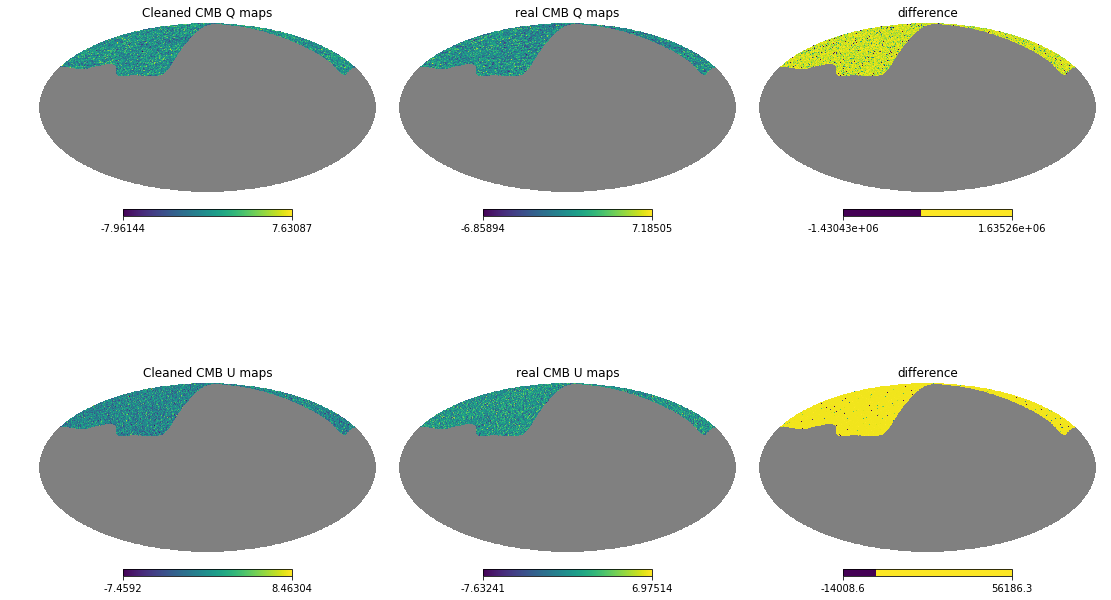

In [200]:
plt.figure(figsize = (15,10))
hp.mollview(Mask(cmb_clean[1]), sub = (231), title = 'Cleaned CMB Q maps'); 
hp.mollview(cmb_ma[1], sub = (232), title = 'real CMB Q maps')

hp.mollview((cmb_ma[1] - Mask(cmb_clean[1]))/Mask(cmb_clean[1])*100 , sub = (233), title = 'difference', norm = 'hist')


hp.mollview(Mask(cmb_clean[2]), sub = (234), title = 'Cleaned CMB U maps'); 
hp.mollview(cmb_ma[2], sub = (235), title = 'real CMB U maps')
hp.mollview((cmb_ma[2] - Mask(cmb_clean[2]))/Mask(cmb_clean[2]), sub = (236), title = 'difference', norm = 'hist')

plt.savefig('/home/jianyao/Ali_maps/results/0212/Cleaned_maps_QU.png', format = 'png')

In [ ]:
# COMPONENT GROUP 1: cmb                                                                                                                                                                                                                     
# COMPONENT GROUP 2: synchrotron freefree thermaldust spindust co
# COMPONENT GROUP 3: faintradiops faintirps thermalsz firb
# COMPONENT GROUP 4: strongirps strongradiops

## ILC in pixel space

In [5]:
nside = 128

ali_ma_512 = hp.read_map("/smc/jianyao/Ali_maps/ali_mask_wo_edge_512.fits", verbose=False)
ali_128 = hp.ud_grade(ali_ma_512, nside_out=nside)

ali_ma_128 = np.zeros(12*nside**2)
ali_ma_128[ali_128 == 1] = 1

index = np.arange(12*nside**2)
mask_index = index[ali_ma_128 == 1]

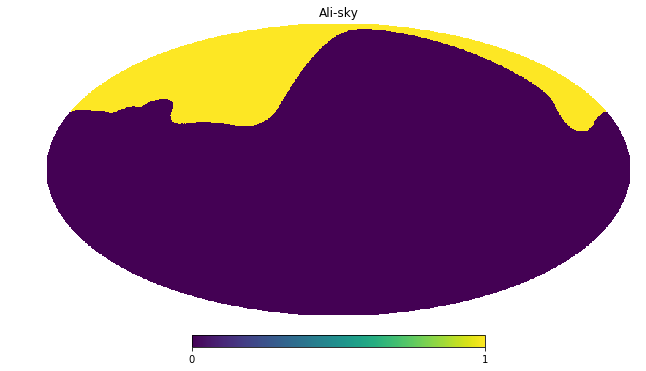

In [4]:
hp.mollview(ali_ma_512, title = 'Ali-sky')

In [244]:
ps_e = Pseudo_Cl(mask_in = ali_ma_128, nside = 128, bin_w = 20, lmax = 250)

In [246]:
Nf = 3; nside = 512
for i in range(SamNum):
    if i < 50:
        noise_95 = hp.ud_grade(hp.read_map('/fnx/jianyao/Noise_realizations/95GHz/noise_realizations_95GHz_%s.fits'%(i), field = None, verbose = False),nside_out = nside)
        noise_150 = hp.ud_grade(hp.read_map('/fnx/jianyao/Noise_realizations/150GHz/noise_realizations_150GHz_%s.fits'%(i), field = None, verbose = False),nside_out = nside)
    else: 
        noise_95 = hp.ud_grade(hp.read_map('/fnx/jianyao/Noise_realizations/95GHz/noise_95GHz_%s.fits'%(i), field = None, verbose = False),nside_out = nside)
        noise_150 = hp.ud_grade(hp.read_map('/fnx/jianyao/Noise_realizations/150GHz/noise_150GHz_%s.fits'%(i), field = None, verbose = False),nside_out = nside)
    

    noise_353 = 1e6*hp.ud_grade(hp.read_map('/fnx/jianyao/Noise_realizations/353GHZ_PLA/noise_353_full_map_mc_%05d.fits'%i, field = None, verbose = False), nside_out=nside)
    
    Noise = np.zeros((Nf,3,12*nside**2)); Noise_B = np.zeros((Nf, 12*128**2))
#     Noise[0] = noise_44;
#     Noise[0] = deconv(noise_70, beam_in = 13.0765, beam_out = beam_low, lmax = lmax + 100);
    Noise[0] = noise_95;  
    Noise[1] = deconv(noise_150, beam_in = 11, beam_out = beam_low, lmax = lmax + 100); 
    Noise[2] = deconv(noise_353, beam_in = 4.944, beam_out = beam_low, lmax = lmax + 100);

    for fre in range(Nf):
        
        purify_N = PurifyB(Noise[fre], ali_ma_512)  ### ring part of the Ali patch 
        noise_bb_i = purify_N.lin_resi()
        
        Noise_B[fre] = hp.ud_grade(noise_bb_i, nside_out = 128)    
    
    nl_bb_i = ps_e.Cross_TT(Noise_B)
    np.save('/fnx/jianyao/ancillary_data/Group3_4_fre_LH_Namaster_noisy_95GHz_beam/Nl_bb_ILC_P/nl_cross_bb_%s.npy'%i, nl_bb_i)
    

In [12]:
mask = nmt.mask_apodization(ali_ma_128,  6, apotype='C2')

b = nmt.NmtBin(nside, nlb=20, lmax= 250); ell_n = b.get_effective_ells(); eln2 = utils.l2(ell_n)

def compute_master(f_a, f_b, wsp):
    cl_coupled = nmt.compute_coupled_cell(f_a, f_b)
    cl_decoupled = wsp.decouple_cell(cl_coupled)
    return cl_decoupled

map0 = np.ones((12*nside**2))
m0 = nmt.NmtField(mask, [map0])  ##, beam=bl

w = nmt.NmtWorkspace()
w.compute_coupling_matrix(m0, m0, b)

In [13]:
SamNum = 100; 

Cl_ilc_rs = np.zeros((SamNum, len(ell_n))); # E and B mode together 

# Nl_ilc_rs = np.zeros((2, SamNum, Q))
sel = np.array((1,2,3)); Nf = len(sel); W = np.zeros((SamNum, Nf))
for n in range(SamNum):
    
    total_i = np.load('/fnx/jianyao/ancillary_data/Group3_4_fre_LH_Namaster_noisy_95GHz_beam/total_map_unmasked/total_BBmap_deconv_unmasked__%03d.npy'%n)
    total = total_i[1:4];
    total_128 = hp.ud_grade(total, nside_out=128)
    
    total_Q = np.zeros((Nf, 12*nside**2)) ; total_U = np.zeros((Nf, 12*nside**2))## two frequencies

    for i in range(Nf):
        total_Q[i][mask_index] = total_128[i][mask_index] ##only BB maps from LH's method
#         total_U[i][mask_index] = total_128[i][2][mask_index]

    Cov_Q = np.zeros((Nf, Nf)); w_Q = np.zeros(Nf)
#     Cov_U = np.zeros((Nf, Nf)); w_U = np.zeros(Nf)

    for i in range(Nf):
        for j in range(Nf):
            Cov_Q[i, j] = np.dot(total_Q[i][mask_index] - np.mean(total_Q[i][mask_index]), total_Q[j][mask_index] - np.mean(total_Q[j][mask_index]))/1.0/len(mask_index)
#             Cov_U[i, j] = np.dot(total_U[i][mask_index] - np.mean(total_U[i][mask_index]), total_U[j][mask_index] - np.mean(total_U[j][mask_index]))/1.0/len(mask_index)

    Cov_Q_inv = np.linalg.pinv(Cov_Q)
#     Cov_U_inv = np.linalg.pinv(Cov_U)


    for i in range(Nf):
        w_Q[i] = np.sum(Cov_Q_inv[i,:])/np.sum(Cov_Q_inv)
#         w_U[i] = np.sum(Cov_U_inv[i,:])/np.sum(Cov_U_inv)


    cmb_Q = np.dot(w_Q, total_Q); #cmb_U = np.dot(w_U, total_U)
    
#     cmb_QU = np.row_stack((cmb_Q, cmb_U))
#     hp.write_map('/fnx/jianyao/RS_clean_CMB/RS_Cleaned_QU_%03d.fits'%(n),cmb_QU, coord='G', column_names= names, column_units='uK_CMB')

#     cmb_I = np.zeros_like(cmb_Q);
#     cmb_ILC_pix = np.row_stack((cmb_I, cmb_Q, cmb_U))

    m1 = nmt.NmtField(mask, [cmb_Q])
    Cl_ilc_rs[n] = compute_master(m1, m1, w)[0]  #hp.anafast(cmb_ILC_pix, lmax = lmax, nspec = 3)
    W[n] = w_Q
    

In [23]:
# apply the weights on the noise power spectrum;

for i in range(SamNum):
    nl_i = 0
    nl_i += np.load('/fnx/jianyao/ancillary_data/Group3_4_fre_LH_Namaster_noisy_95GHz_beam/Nl_bb_ILC_P/nl_cross_bb_%s.npy'%i);
    
nl_i = nl_i*1.0/SamNum 


In [50]:
w_mean = np.matrix(np.mean(W, axis = 0))
nl_ps = np.zeros(len(ell_n))

for l in range(len(ell_n)):
    nl_ps[l] = w_mean*(nl_i[l])*w_mean.T

### ILC power spectrum

In [24]:
cl_95 = np.load('/fnx/jianyao/cmb_0.05_realizations/cl_bb_95GHz_LH_Namaster.npy')

In [25]:
cl_ilc_rs_mean = np.mean(Cl_ilc_rs, axis = 0); 
cl_ilc_rs_std = np.std(Cl_ilc_rs, axis = 0); 

Text(0.5, 1.0, 'ILC BB in pixel space')

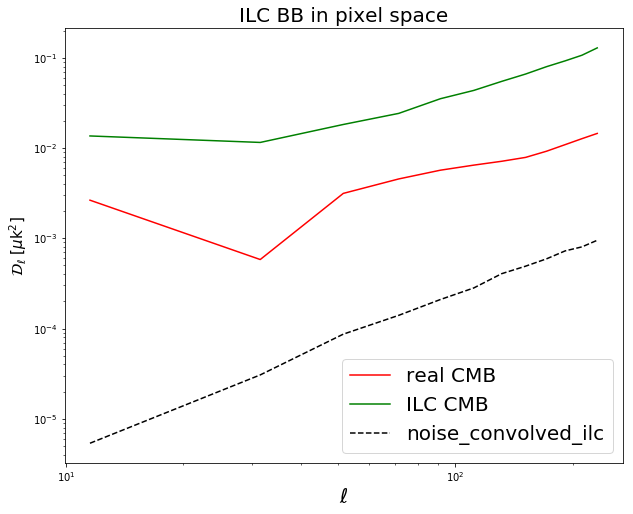

In [52]:
psn = ['EE', 'BB']; mode = 1
fig1 = plt.figure(1, figsize=(10,8))
# plt.axis('off')
# frame1=fig1.add_axes((.1,.4,.8,.5)) # x0, y0, width, height
plt.loglog(ell_n,eln2*cl_95[0:12], 'r-',label = 'real CMB')
plt.loglog(ell_n,eln2*(cl_ilc_rs_mean - nl_ps), 'g-', label = 'ILC CMB')
plt.loglog(ell_n,eln2*nl_ps, 'k--', label = 'noise_convolved_ilc')

# plt.errorbar(Ell,Ell*(Ell+1)*(cl_ilc_rs_mean - nl_ilc_rs_mean)/2/np.pi, yerr = Ell*(Ell+1)/2/np.pi*cl_ilc_rs_std,fmt='bo',capthick = 0.1)

plt.xlabel('$\ell$', fontsize = 20); 
plt.ylabel(r'$\mathcal{D}_{\ell}$ [$\mu$k$^2$]', fontsize = 15)
plt.legend(fontsize = 20)
plt.title('ILC %s in pixel space'%psn[mode], fontsize = 20)

# frame2=fig1.add_axes((.1,.1,.8,.3))
# plt.semilogx(Ell, (cl_ilc - cls)/cls*100, 'k--')
# plt.axhline(0,color = 'k')
# plt.ylabel(r'$\Delta \mathcal{D}_\ell$/$\mathcal{D}^{real}_{\ell} $ [%]', fontsize = 15);plt.xlabel(r'$\ell$', fontsize = 20)
# plt.ylim(-100, 100)
# plt.savefig('/home/jianyao/Ali_maps/results/0221_ILC_pixel/ILC_pixel_%s.jpg'%psn[mode], format = 'png')

# ABS

In [264]:
b = nmt.NmtBin(512, nlb=20, lmax=1000); ell_n = b.get_effective_ells(); eln2 = utils.l2(ell_n)

## noise mean ps and std

In [212]:
SamNum = 100; path = '/fnx/jianyao/ancillary_data/Group2_only_4_fre_LH_Namaster_noisy_95GHz_beam/'
Q = len(ell_n); Nf = 4
nl_all_bin = np.ones((SamNum, Q, Nf, Nf))

for i in range(SamNum):
    noise_ps_i = np.load('%s/Nl_bb/nl_cross_bb_%s.npy'%(path, i))
    
    # Namaster results has binned in advance.
    # LH's maps only have BB mode.
    
    nl_all_bin[i] = noise_ps_i #bin_l(noise_ps_i[0], lmax, Q); 
#     nl_all_bin[i,1] = noise_ps_i[1] #bin_l(noise_ps_i[1], lmax, Q)
    
nl_bin_mean_all = np.mean(nl_all_bin, axis = 0); nl_bin_std_all = np.std(nl_all_bin, axis = 0)

# np.save('%s/Nl_bb/nl_bin_mean.npy'%path, nl_bin_mean_all); np.save('%s/Nl_bb/nl_bin_std_all.npy'%path, nl_bin_std_all)

In [156]:
def Select_fre(total_fre, sel):
    
    '''
    Take some part of the cross power spectrum matrix
    
    '''

    n_fre = len(sel)
    
    total_bin = np.ones((Q, n_fre, n_fre)); 
    
    for q in range(Q):
        x = 0; 
        for i in (sel):
            y = 0;
            for j in (sel):
                
                total_bin[q][x,y] = total_fre[q][i, j];
                
                y += 1;
                
            x += 1;
            
    return total_bin

In [199]:
sel = np.array((0,1,2,3)); mode = 1;  Nf = len(sel)

nl_bin_mean = Select_fre(nl_bin_mean_all, sel); nl_bin_std = Select_fre(nl_bin_std_all, sel);

## ABS main 

In [278]:
D_B = np.zeros((SamNum, Q)); s = 5.00827749e-5; Delta = 10*s; 


##  mode = 0 for EE or 1 for BB mode
for n in range(SamNum):
    total_ps = np.load('%s/Cl_bb/cross_bb_%03d.npy'%(path,n))
    D_B_n = np.zeros(Q);
    
    #utils.bin_l(total_ps[mode],lmax,Q); select part of the cross power spectrum 
    D = Select_fre(total_ps, sel)
    
    f = []; Evals = np.ones((Q,Nf)); E_cut = 2
    sigmaD = np.zeros(Q)
    
    for i in range(Q):
        f_q = np.ones(Nf)
        for j in range(Nf):
            f_q[j] = f_q[j]/np.sqrt(nl_bin_std[i][j, j])   ##nl_std_all.shape = (2, Q, Nf, Nf)
        f.append(f_q) 

    for l in range(Q):
        D[l] = D[l] - nl_bin_mean[l] 
        for i in range(Nf): 
            for j in range(Nf):
                D[l][i,j] = D[l][i,j]/np.sqrt(nl_bin_std[l][i, i]*nl_bin_std[l][j, j]) + Delta*f[l][i]*f[l][j] 

    for l in range(0,Q): 
        e_vals,E = LA.eig(D[l])
        Evals[l,:] = e_vals        

        for i in range(Nf):
            E[:,i]=E[:,i]/LA.norm(E[:,i])**2  

        D_B_l = 0; sigmaD_l = 0; G = np.ones(Nf)
        for i in range(Nf):
            if e_vals[i]>=E_cut:
                G_i = np.dot(f[l],E[:,i])
                D_B_l += (G_i**2/e_vals[i])

        D_B_l = 1.0/ D_B_l - Delta
        D_B_n[l] = D_B_l

#         ### Calculate the theoretical error of ABS method using perturbation theory...
#         for i in range(Nf):
#             G[i]= np.dot(f[l],E[:,i])
#             sigmaD[l] += (G[i]**2/e_vals[i]**2)*(clbb_clean[l] + Delta)**2
        
#         ## for C_alpha
#         if l == Q-11:
#             evals_test = e_vals
#             con_i = np.ones(Nf)
#             for i in range(Nf):
#                 G_test= np.dot(f[l],E[:,i])
#                 con_i[i] = (G_test**2/e_vals[i])
    
#             for i in range(Nf):
#                 con_i[i] = con_i[i]/np.sum(con_i)
        
    D_B[n] = D_B_n
    
D_B_mean = np.mean(D_B, axis = 0)
D_B_std = np.std(D_B, axis = 0)

D_B_mean_std = np.row_stack((D_B_mean, D_B_std))

In [201]:
# cl_95 = np.load('/fnx/jianyao/cmb_0.05_realizations/cl_bb_95GHz_LH.npy')
# cl_95_bin = utils.bin_l(cl_95, lmax, Q)

cl_95_bin = np.load('/fnx/jianyao/cmb_0.05_realizations/cl_bb_95GHz_LH_Namaster.npy')
# cl_95_bin = utils.bin_l(cl_95, lmax, Q)

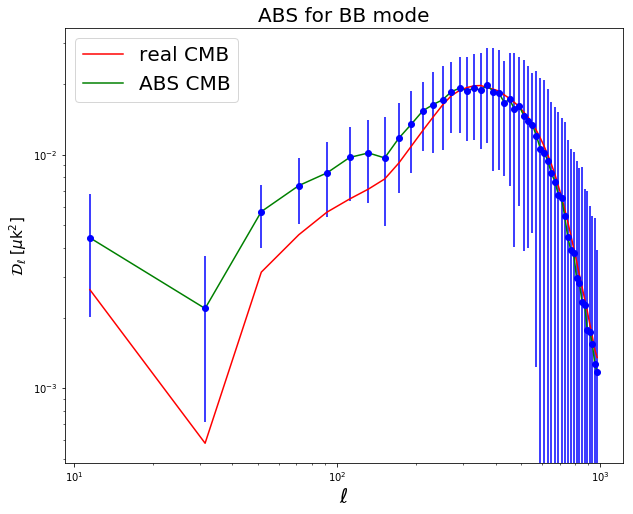

In [280]:
fig1 = plt.figure(1, figsize=(10,8))
# plt.axis('off')
# frame1=fig1.add_axes((.1,.4,.8,.5)) # x0, y0, width, height
plt.loglog(ell_n,eln2*cl_95_bin, 'r-',label = 'real CMB')
# plt.loglog(Ell, Ell*(Ell+1)/2/np.pi*(cl_ilc_mean), 'k--', label = 'ILC CMB ')

plt.loglog(ell_n,eln2*(D_B_mean), 'g-', label = 'ABS CMB')
# plt.loglog(Ell, Ell*(Ell+1)/2/np.pi*nl_ilc_rs_mean, 'k--', label = 'noise_convolved_ilc')

plt.errorbar(ell_n, eln2*(D_B_mean), yerr = eln2*D_B_std,fmt='bo',capthick = 0.1)
# plt.errorbar(Ell,Ell*(Ell+1)*cl_ilc_mean/2/np.pi, yerr = Ell*(Ell+1)/2/np.pi*cl_ilc_std,fmt='yo',capthick = 0.1)


plt.xlabel('$\ell$', fontsize = 20); 
plt.ylabel(r'$\mathcal{D}_{\ell}$ [$\mu$k$^2$]', fontsize = 15)
plt.legend(fontsize = 20)
plt.title('ABS for %s mode'%psn[mode], fontsize = 20)
plt.savefig('/home/jianyao/Ali_maps/results/0409_Namaster_after_LH/ABS_group2_only_%s_3fre_353_.jpg'%psn[mode], format = 'jpg')

In [281]:
np.save('/home/jianyao/Ali_maps/results/Cleaned_PS/ABS_PS/Cl_group2_only.npy', D_B_mean_std)

## ILC and ABS results

In [283]:
cl_ilc = np.load('/home/jianyao/Ali_maps/results/Cleaned_PS/ILC_PS/Cl_Group2_only_4_fre_LH_Namaster_noisy_95GHz_beam.npy')

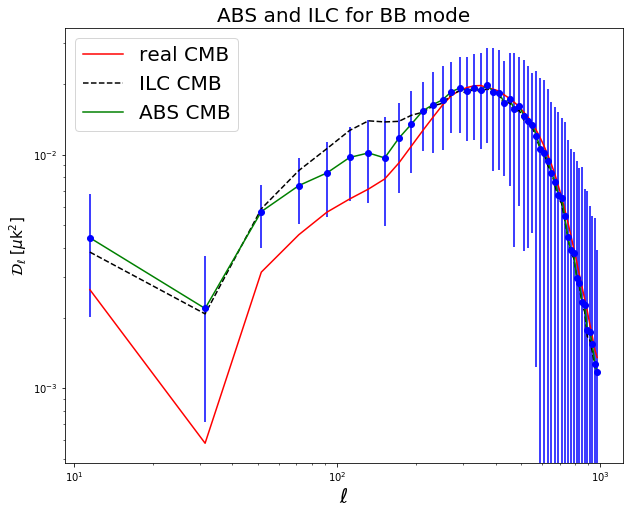

In [288]:
fig1 = plt.figure(1, figsize=(10,8))
# plt.axis('off')
# frame1=fig1.add_axes((.1,.4,.8,.5)) # x0, y0, width, height
plt.loglog(ell_n,eln2*cl_95_bin, 'r-',label = 'real CMB')
plt.loglog(ell_n,eln2*cl_ilc[0],'k--', label = 'ILC CMB ')

plt.loglog(ell_n,eln2*(D_B_mean), 'g-', label = 'ABS CMB')
# plt.loglog(Ell, Ell*(Ell+1)/2/np.pi*nl_ilc_rs_mean, 'k--', label = 'noise_convolved_ilc')

plt.errorbar(ell_n, eln2*(D_B_mean), yerr = eln2*D_B_std,fmt='bo',capthick = 0.1)
# plt.errorbar(Ell,Ell*(Ell+1)*cl_ilc_mean/2/np.pi, yerr = Ell*(Ell+1)/2/np.pi*cl_ilc_std,fmt='yo',capthick = 0.1)


plt.xlabel('$\ell$', fontsize = 20); 
plt.ylabel(r'$\mathcal{D}_{\ell}$ [$\mu$k$^2$]', fontsize = 15)
plt.legend(fontsize = 20)
plt.title('ABS and ILC for %s mode'%psn[mode], fontsize = 20)
plt.savefig('/home/jianyao/Ali_maps/results/0409_Namaster_after_LH/ABS_and_ILC_group2_only_%s_3fre_353_.jpg'%psn[mode], format = 'jpg')

# Writing into fits file

In [30]:
names = ['Q_polarization', 'U_polarization']

In [33]:
hp.write_map('/fnx/jianyao/HS_clean_CMB/Cleaned_QU_%03d.fits'%(1),cmb_clean[1:], coord='G', column_names= names, column_units='uK_CMB')

In [34]:
clean_test = hp.read_map('/fnx/jianyao/HS_clean_CMB/Cleaned_QU_%03d.fits'%(1), h = True, field = None)

NSIDE = 512
ORDERING = RING in fits file
INDXSCHM = IMPLICIT


In [29]:
cmb_clean[1:].shape

(2, 3145728)

# Calculate the PS of noise and total_ps

In [164]:
## To generate one realization of noise maps. 

n3test = hp.read_map('/smc/jianyao/Ali_maps/Noise_maps/fits/I_Noise_150_G_1024.fits', partial=True)
n3zeros = n3test*0 #0,0,nan,nan......
nIQU = np.zeros((3, len(n3test)))
index = np.arange(len(n3test))#index[n2zeros == 0]
# for i in index[n2test <= 5]:
SamNum = 50
for n in range(50, 50+SamNum):
    
    for i in index[n3zeros==0]:#[n3zeros==0]:    #full_ali map, without mask out the edge.
        nIQU[0][i] = np.random.normal(0, n3test[i])
        nIQU[1][i] = np.random.normal(0, n3test[i]*np.sqrt(2))
        nIQU[2][i] = np.random.normal(0, n3test[i]*np.sqrt(2))

    hp.write_map('/fnx/jianyao/Noise_realizations/150GHz/noise_150GHz_%s.fits'%(n), nIQU)

NSIDE = 1024
ORDERING = RING in fits file
INDXSCHM = IMPLICIT


In [26]:
i

3